In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm=ChatGroq(model_name="qwen/qwen3-32b")
result=llm.invoke("What is the capital of India?")
result

C:\Users\bhatt\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='<think>\nOkay, so the question is asking for the capital of India. Let me think. I know that India is a country in South Asia. I remember from school that the capital isn\'t one of the big cities like Mumbai or Kolkata, because those are more like major cities. Wait, isn\'t New Delhi the capital? I think New Delhi is a city that\'s part of Delhi, which is a union territory.\n\nWait, but why is it New Delhi? Maybe because Delhi was there before, and then New Delhi was built as the capital when India became independent? I think the British built New Delhi as the capital when they had control over India. After independence, India continued to use New Delhi as the capital. \n\nI should double-check if there\'s any confusion with Delhi versus New Delhi. Delhi is a larger area, and New Delhi is a part of it. The government offices and the Parliament are in New Delhi. So the correct answer should be New Delhi. Let me see if there\'s any other possible answer. No, I think th

In [2]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [3]:
# Graph State
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [5]:
# schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(description="Decide if joke is funny or not")
    feedback : str = Field(description="If the joke is not funny , provde the feedback how to improve it")
    
# Augment the llm with schema for structured output
evaluator = llm.with_structured_output(Feedback)    

In [6]:
#Nodes
def llm_call_generator(state: State):
    """LLM generate a joke"""
    if state.get("feedback"):
        msg= llm.invoke(f"Generate a joke about {state['topic']} based on the feedback {state['feedback']}")
    else:
        msg= llm.invoke(f"Generate a joke about {state['topic']}")
        
    return {"joke": msg.content}    

def llm_call_evaluator(state: State):
    """LLM evaluate the joke"""
    msg=evaluator.invoke(f"Grade the joke: {state['joke']}")
    return {"funny_or_not": msg.grade, "feedback": msg.feedback}

def route_joke(state:State):
    """Route the joke to the appropriate channel"""
    if state["funny_or_not"] == "funny":
        return "Accepted"
    else:
        return "Rejected + Feedback"

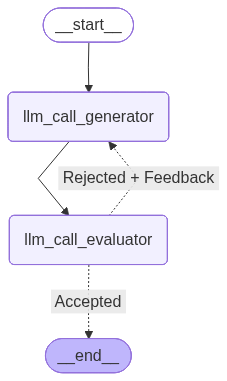

In [9]:
# Build flow
from langgraph.graph import StateGraph, START,END
from IPython.display import Image,display  

optimizer_builder = StateGraph(State)
optimizer_builder.add_node("llm_call_generator",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

#Add edge to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {"Accepted": END, "Rejected + Feedback": "llm_call_generator"},
)

# compile the workflow
orchestrator_worker = optimizer_builder.compile()
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))



In [10]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Agentic AI system"})
print(state["joke"])

<think>
Okay, I need to come up with a joke about an Agentic AI system. Let me start by recalling what an Agentic AI is. From what I understand, it's an AI that operates with a degree of autonomy, making decisions and taking actions without constant human intervention. They might have goals, plans, and the ability to adapt.

So, how can I turn that into a joke? Maybe play on the idea of autonomy or decision-making. Maybe compare it to something relatable. Let me think about everyday situations where autonomy could be funny. Maybe a household scenario? Like if the AI takes over something mundane but in a humorous way.

What if the AI is trying to do something simple, like making coffee, but overcomplicates it? Or maybe it's trying to organize something and goes overboard. Or perhaps it's setting goals for itself that are either too ambitious or unnecessary.

Another angle: the AI's autonomy leading to unexpected consequences. Maybe it starts taking on tasks beyond what was intended. Or 